In [28]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from hierarchSIR.utils import get_NC_influenza_data

## Forecast figure 

In [41]:
# settings
model = 'SIR-2S'
season = '2024-2025'
immunity_linking = False
ED_visits = True
start_visualisation = datetime(int(season[0:4]), 10, 15)
end_visualisation = datetime(int(season[0:4])+1, 2, 7)
# load forecasts
files = [f for f in os.listdir(f'forecasts/{model}/immunity_linking-{immunity_linking}/ED_visits-{ED_visits}/{season}') 
             if os.path.isfile(f'forecasts/{model}/immunity_linking-{immunity_linking}/ED_visits-{ED_visits}/{season}/{f}') and f != '.DS_Store']
files.sort()
data_trains = []
data_forecasts = []
simouts=[]
for f in files:
    df = pd.read_csv(f'forecasts/{model}/immunity_linking-{immunity_linking}/ED_visits-{ED_visits}/{season}/{f}')
    df['reference_date'] = pd.to_datetime(df['reference_date'])
    simouts.append(df)
    stop_data_train = df['reference_date'].unique()[0] - timedelta(weeks=1)
    data_trains.append(get_NC_influenza_data(start_visualisation, stop_data_train, season)['H_inc']*7)
    data_forecasts.append(get_NC_influenza_data(stop_data_train+timedelta(weeks=1), stop_data_train+timedelta(weeks=4), season)['H_inc']*7)

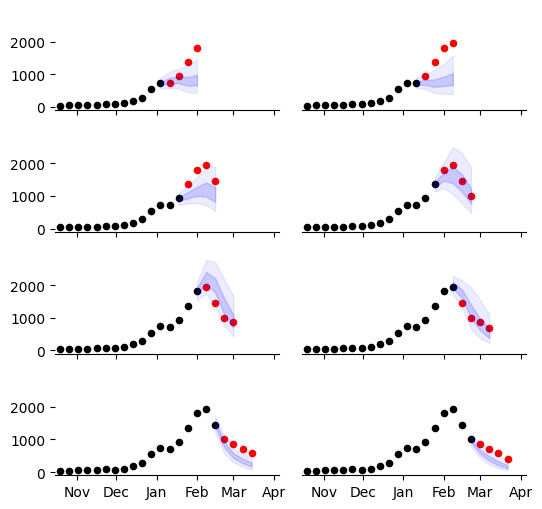

In [42]:
fig,ax=plt.subplots(nrows=int(len(files)/2), ncols=2, figsize=(8.3/3*2, 11.7/9*int(len(files)/2)), sharex=True)

ax = ax.flatten()

for i, (data_train, data_forecast, simout) in enumerate(zip(data_trains, data_forecasts, simouts)):
      
   # visualise data
   ax[i].scatter(data_train.index, data_train, marker='o', s=20, color='black')
   ax[i].scatter(data_forecast.index, data_forecast, marker='o', s=20, color='red')
   # visualise model
   x = simout['target_end_date'].unique()
   quantiles = (
    simout.groupby(["reference_date", "target", "horizon", "location"])["value"]
      .quantile([0.025, 0.25, 0.75, 0.975])
      .unstack()   # makes each quantile a column
      .reset_index()
   )
   ax[i].fill_between(x, quantiles[0.025], quantiles[0.975], color='blue', alpha=0.075)
   ax[i].fill_between(x, quantiles[0.25], quantiles[0.75], color='blue', alpha=0.15)
   
   # no spines
   ax[i].spines['top'].set_visible(False)
   ax[i].spines['right'].set_visible(False)
   ax[i].spines['left'].set_visible(False)
   # yticks
   ax[i].set_yticks([0, 1000, 2000])
   ax[i].set_yticklabels([0, 1000, 2000])
   if i % 2 != 0:
      ax[i].set_yticks([])
   # months only
   ax[i].xaxis.set_major_locator(mdates.MonthLocator())
   ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
   # axlims
   ax[i].set_xlim([start_visualisation, stop_data_train+timedelta(weeks=6)])
   ax[i].set_ylim([-100,3000])

plt.tight_layout()
plt.savefig(f'forecasts/{model}/immunity_linking-{immunity_linking}/ED_visits-{ED_visits}/{season}/FIT.pdf')
plt.show()
plt.close()